In [2]:
# import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

In [3]:
# Import important libraries

import math
import numpy as npy
import pandas as pds
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

# import scikitplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils


In [4]:

dfs = pds.read_csv('data/fer2013/fer2013/fer2013.csv')
df = pds.read_csv('output/fer-2013-images_preprocessed.csv')
print(df.shape)
df


(28709, 3)


,filename,emotion,image
0,angry\im0.png,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,angry\im1.png,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,angry\im10.png,0,117 116 113 99 78 53 37 34 33 32 31 28 27 30 2...
3,angry\im100.png,0,159 159 145 159 167 161 166 161 170 188 179 16...
4,angry\im1000.png,0,254 254 254 252 235 186 149 156 79 45 33 34 24...
...,...,...,...
28704,surprised\im995.png,6,189 160 144 139 134 135 104 49 47 33 26 20 15 ...
28705,surprised\im996.png,6,145 182 212 139 20 14 12 13 39 44 37 53 104 14...
28706,surprised\im997.png,6,10 16 19 20 20 15 19 33 80 87 111 138 137 142 ...
28707,surprised\im998.png,6,141 148 156 163 171 175 179 184 186 188 191 19...


In [5]:
type(df.image.values)

numpy.ndarray

In [6]:
df.emotion.unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [7]:
# emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
emotion_label_to_text = {0:'angry', 1:'disgusted', 2:'fearful', 3:'happy', 4: 'neutral', 5: 'sad', 6: 'surprised'}
emotion_label_to_text

{0: 'angry',
 1: 'disgusted',
 2: 'fearful',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprised'}

In [8]:
df.emotion.value_counts().unique()

array([7215, 4965, 4830, 4097, 3995, 3171,  436], dtype=int64)

In [9]:
df.emotion.value_counts()

3    7215
4    4965
5    4830
2    4097
0    3995
6    3171
1     436
Name: emotion, dtype: int64

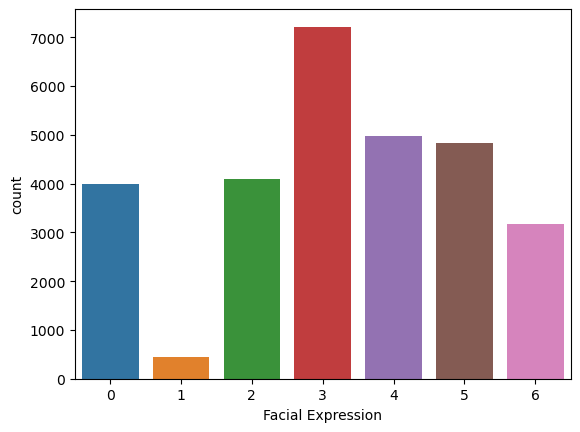

In [10]:
sns.countplot(df, x=df.emotion)
plt.xlabel('Facial Expression')
plt.show()

In [11]:
# math.sqrt(len(dfs.pixels[0].split(' ')))
math.sqrt(len(df.image[0].split(' ')))

48.0

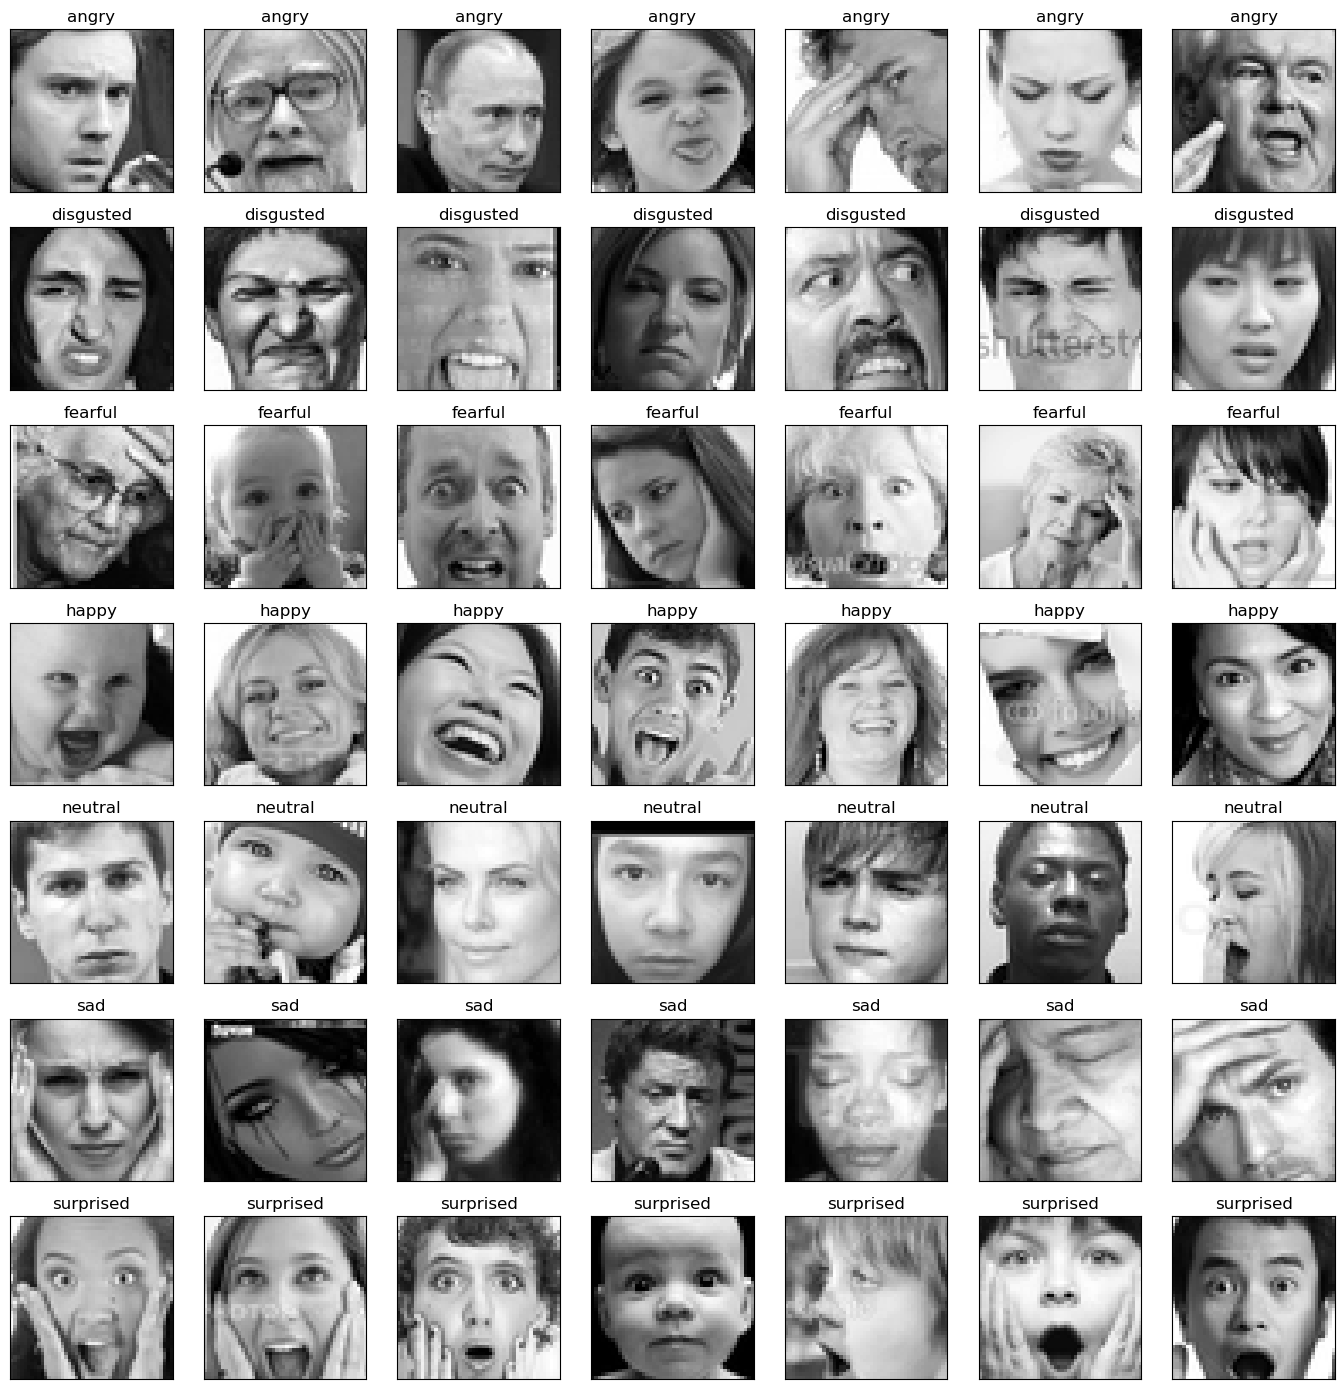

In [12]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].image.iloc[k]
        px = npy.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [13]:
INTERESTED_LABELS = [3, 4, 6]

In [14]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(15351, 3)

In [15]:
img_array = df.image.apply(lambda x: npy.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = npy.stack(img_array, axis=0)

In [16]:
img_array.shape

(15351, 48, 48, 1)

In [17]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(15351, 3)

In [18]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((12280, 48, 48, 1), (3071, 48, 48, 1), (12280, 3), (3071, 3))

In [20]:
del df
del img_array
del img_labels

In [21]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]
print(f'Image width: {img_width};\nImage Height: {img_height};\nImage Depth: {img_depth};\nClass Number: {num_classes}')

Image width: 48;
Image Height: 48;
Image Depth: 1;
Class Number: 3


In [22]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [23]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [24]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [25]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
ask_epoch = 20
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1]) 


Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

In [26]:
# Code by https://www.kaggle.com/code/gpiosenka/callback-to-continue-or-halt-training-f1-90
from tensorflow import keras
import time
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.subask_epoch = int(ask_epoch/2)
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training     
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou earlier specified a maximum epochs of ', self.epochs, '\n, its seems that you want to train for a total of', self.ask_epoch,'\n\n Please confirm your action, please enter "Y", or "N" to end training at ', self.epochs)
                        ans=input()
                        
                        if ans == 'Y' or ans =='y':
                            self.epochs = self.ask_epoch
                        else:
                             print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        
ask=ASK(model, epochs,  ask_epoch)

In [27]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""
# starting the Checkpoint for the model
# checkpoint_dir = os.path.dirname(checkpoint_path)

check_point = ModelCheckpoint(
                                          filepath='models/fedav_DNN_best_model.h5',
                                          save_weights_only=True,
                                          save_best_only=True, 
                                          monitor="val_accuracy",
                                          verbose = 1,
                                        )

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    check_point,
    early_stopping,
    lr_scheduler,
    ask
]

In [28]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    # steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    # use_multiprocessing=True
)

Training will proceed until epoch 20  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/100
384/384 [==============================] - ETA: 0s - loss: 1.2550 - accuracy: 0.4404
Epoch 1: val_accuracy improved from -inf to 0.53598, saving model to models\fedav_DNN_best_model.h5
384/384 [==============================] - 40s 85ms/step - loss: 1.2550 - accuracy: 0.4404 - val_loss: 0.9786 - val_accuracy: 0.5360 - lr: 0.0010
Epoch 2/100
384/384 [==============================] - ETA: 0s - loss: 0.9462 - accuracy: 0.5551
Epoch 2: val_accuracy improved from 0.53598 to 0.66754, saving model to models\fedav_DNN_best_model.h5
384/384 [==============================] - 31s 80ms/step - loss: 0.9462 - accuracy: 0.5551 - val_loss: 0.7621 - val_accuracy: 0.6675 - lr: 0.0010
Epoch 3/100
384/384 [==============================] - ETA: 0s - loss: 0.8047 - accuracy: 0.6404
Epoch 3: val_accuracy improved from 0.66754 to 0.721

In [ ]:
# Restoring model weights from the end of the best epoch: 52 on label = [3, 4, 6].
# Epoch 52: val_accuracy improved from 0.89515 to 0.89840, saving model to models\fedav_DNN_best_model.h5
# 384/384 [==============================] - 31s 80ms/step - loss: 0.2819 - accuracy: 0.8983 - val_loss: 0.3128 - val_accuracy: 0.8984 - lr: 2.5000e-04


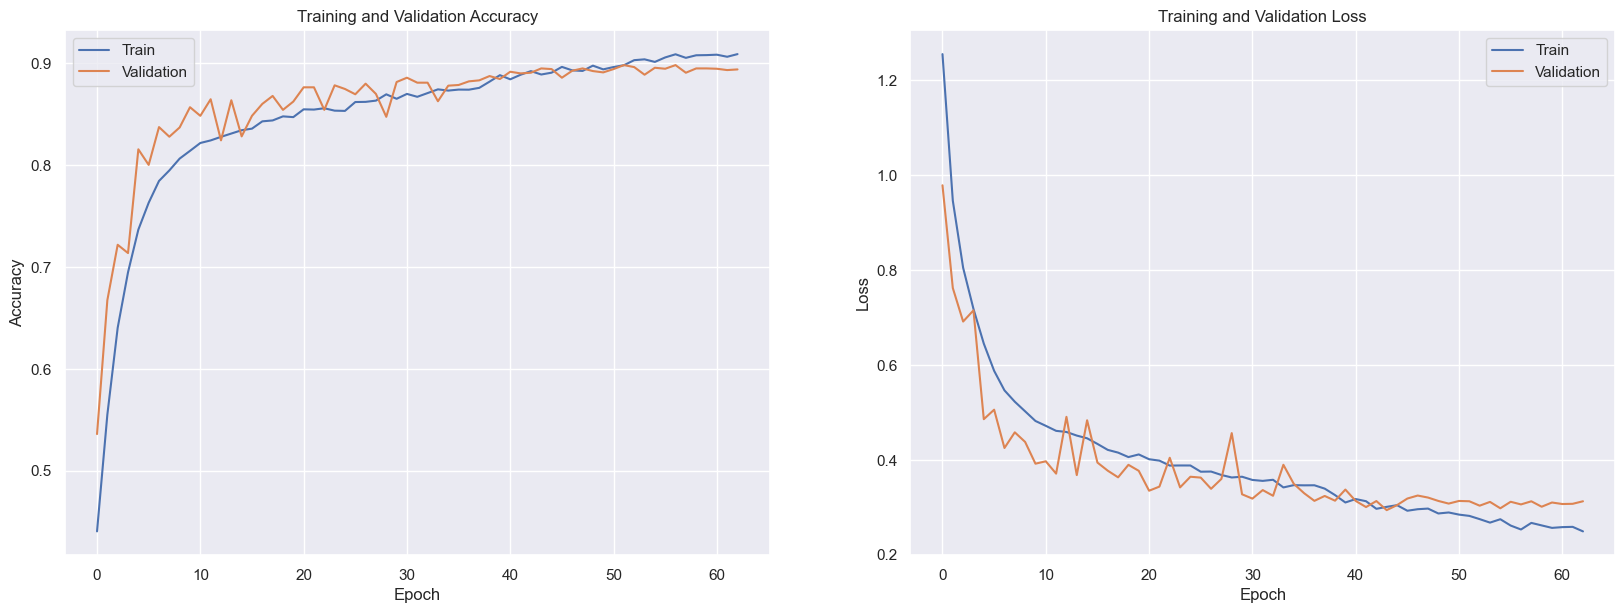

In [33]:
from pylab import rcParams
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
start_epoch = 0
Epoch_count=len(acc)+ start_epoch
Epochs=[]
for i in range (start_epoch ,Epoch_count):
    Epochs.append(i+1)   
index_loss=npy.argmin(val_loss)   #   this is the epoch with the lowest validation loss
val_lowest=val_loss[index_loss]
index_acc=npy.argmax(val_acc)

# summarize history for accuracy using reLU
sns.set()
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')



# summarize history for loss using reLU
plt.subplot(2, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


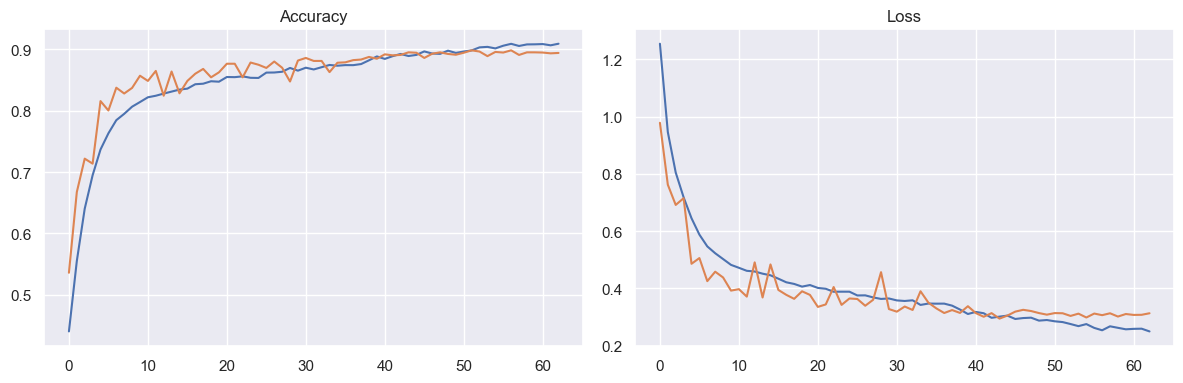

In [32]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot( history.history['accuracy'],)
sns.lineplot(history.history['val_accuracy'],)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot( history.history['loss'],)
sns.lineplot(history.history['val_loss'],)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('images/epoch_history_dcnn.png')
pyplot.show()

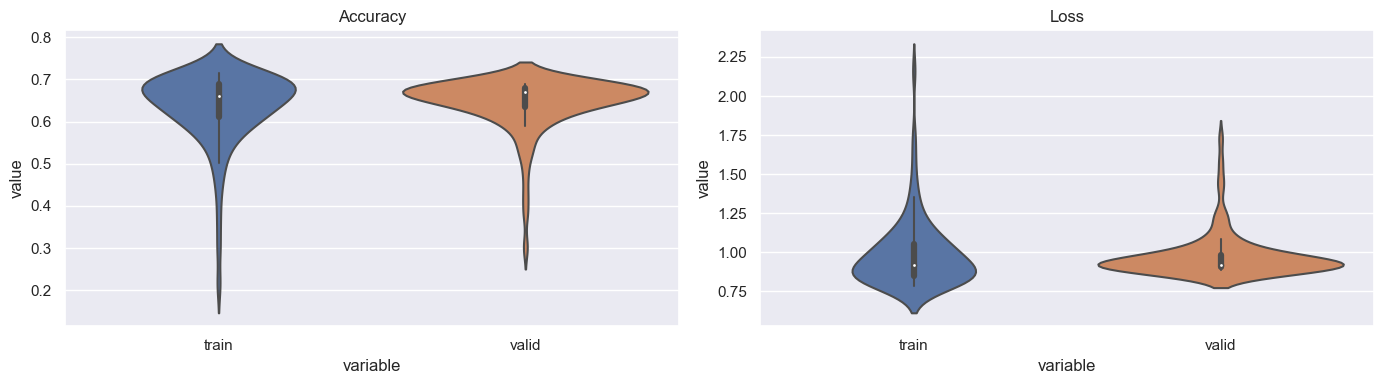

In [ ]:
df_accu = pds.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pds.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pds.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pds.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('images/performance_dist.png')
pyplot.show()

In [ ]:
# Function to Plot Confusion Matrix on the Test Set
def ConfusionMatrix(label_test, label_prep, class_count, class_keys, head = ''):
    from sklearn.metrics import confusion_matrix, accuracy_score
    cm = confusion_matrix(label_test, label_prep)
    accuracy = accuracy_score(label_test, label_prep)

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(npy.arange(class_count)+.5, class_keys, rotation=90)
    plt.yticks(npy.arange(class_count)+.5, class_keys, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix"+head)
    plt.show() 
    # clr = classification_report(
    #                             label_test, 
    #                             label_prep, 
    #                             target_names=class_keys, 
    #                             digits= 4
    #                             ) # create classification report
    # print(f"Classification Report {head}:\n---------------------------------------------\n", clr)

    print('accuracy: ', accuracy)
    
diction = {3:'happiness', 4: 'sadness', 6: 'neutral'}
class_keys = list(diction.keys())

y_pred = npy.argmax(model.predict(X_valid), axis=1)   
print(y_pred) 
# Plot Confusion Matrix with Classification Report on the test batch-size data
ConfusionMatrix(
                y_valid, 
                y_pred, 
                class_count=3, 
                class_keys=class_keys,
                head=' on The Test Batch-Size'
                )


67/67 [==============================] - 11s 158ms/step
[1 2 1 ... 0 2 0]


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [ ]:
yhat_valid = model.predict(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

67/67 [==============================] - 10s 139ms/step


NameError: name 'scikitplot' is not defined

In [43]:
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
}

class_keys = mapper.keys()

96/96 [==============================] - 19s 75ms/step


<Figure size 640x480 with 0 Axes>

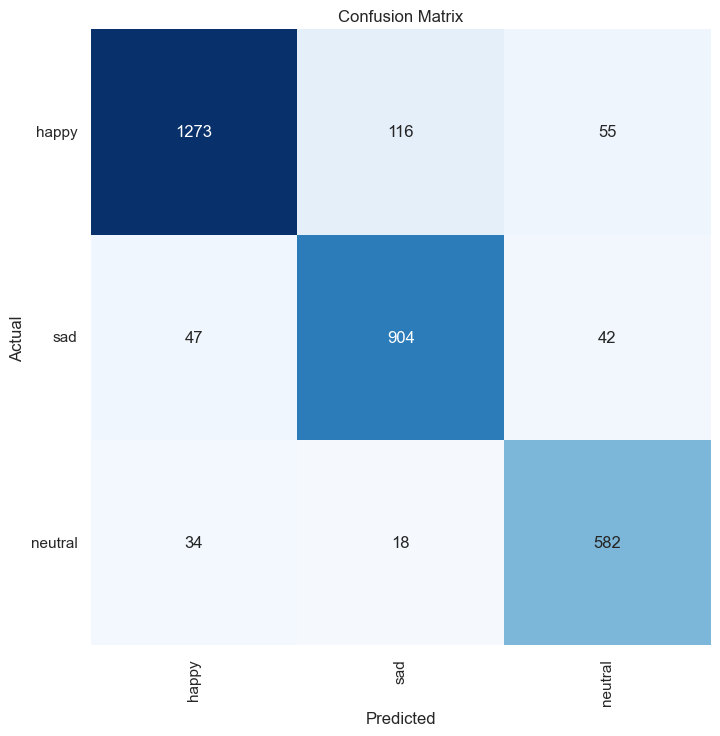

total wrong validation predictions: 312


              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1444
           1       0.87      0.91      0.89       993
           2       0.86      0.92      0.89       634

    accuracy                           0.90      3071
   macro avg       0.89      0.90      0.90      3071
weighted avg       0.90      0.90      0.90      3071

Accuracy:  0.8984044285249104


In [47]:
# import scikitplot as skplt
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score
# predict probabilities for validation set
yhat_valid = model.predict(X_valid)

# convert targets to one-hot encoded format
y_valid_onehot = to_categorical(npy.argmax(y_valid, axis=1))
yhat_valid_onehot = to_categorical(npy.argmax(yhat_valid, axis=1))

# plot confusion matrix
cm = confusion_matrix(npy.argmax(y_valid_onehot, axis=1), npy.argmax(yhat_valid_onehot, axis=1))
pyplot.savefig("confusion_matrix_dcnn.png")

accuracy = accuracy_score(npy.argmax(y_valid_onehot, axis=1), npy.argmax(yhat_valid_onehot, axis=1))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(npy.arange(num_classes)+.5, mapper.values(), rotation=90)
plt.yticks(npy.arange(num_classes)+.5, mapper.values(), rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show() 
    
# print classification report
print(f'total wrong validation predictions: {npy.sum(npy.argmax(y_valid_onehot, axis=1) != npy.argmax(yhat_valid_onehot, axis=1))}\n\n')
print(classification_report(npy.argmax(y_valid_onehot, axis=1), npy.argmax(yhat_valid_onehot, axis=1)))
print('Accuracy: ', accuracy)


1/1 [==============================] - 2s 2s/step


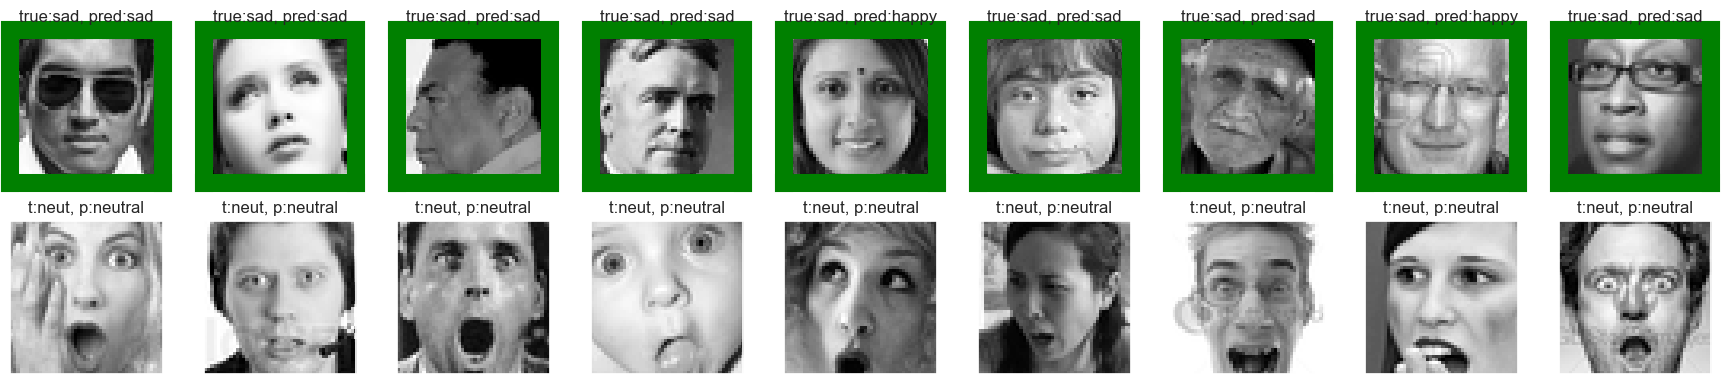

In [54]:
npy.random.seed(2)
random_sad_imgs = npy.random.choice(npy.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = npy.random.choice(npy.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        if npy.argmax(y_valid[i]) == npy.argmax(yhat_valid[i]):
                for axis in ['top','bottom','left','right']:
                        ax.spines[axis].set_linewidth(13)
                        ax.spines[axis].set_color('green')

                        ax.set_title(f"true:sad, pred:{mapper[npy.argmax(model.predict(sample_img.reshape(1,48,48,1)))]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{mapper[npy.argmax(model.predict(sample_img.reshape(1,48,48,1)))]}")

        pyplot.tight_layout()